In [202]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import os
from SmilesPE.pretokenizer import atomwise_tokenizer
from os import path as p
import torchtext
from collections import OrderedDict
import math
import torch.nn.functional as tf
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau
import selfies as sf
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit import Chem
from rdkit import DataStructs
import seaborn as sns

In [167]:
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [168]:
TOKENS = {'[#Branch1]', '[#Branch2]', '[#C-1]', '[#C]', '[#N+1]', '[#N]', '[=As]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N-1]', '[=NH1+1]', '[=NH2+1]', '[=N]', '[=O+1]', '[=O]', '[=P+1]', '[=PH1]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S+1]', '[=SH1]', '[=S]', '[=Se+1]', '[=Se]', '[=Te+1]', '[Al]', '[As]', '[B-1]', '[BH1-1]', '[BH2-1]', '[BH3-1]', '[B]', '[Br]', '[Branch1]', '[Branch2]', '[C+1]', '[C-1]', '[CH1-1]', '[C]', '[Cl+3]', '[Cl]', '[F]', '[H]', '[I+1]', '[I]', '[N+1]', '[N-1]', '[NH1+1]', '[NH1-1]', '[NH1]', '[NH2+1]', '[N]', '[Na]', '[O+1]', '[O-1]', '[OH0]', '[OH1+1]', '[O]', '[P+1]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S+1]', '[S-1]', '[SH1]', '[S]', '[Se+1]', '[SeH1]', '[Se]', '[Si]', '[Te]'}
special_tokens = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]
VOCAB = torchtext.vocab.vocab(ordered_dict=OrderedDict({e:1 for e in TOKENS}), specials=special_tokens)
VOCAB.set_default_index(VOCAB[UNK_TOKEN])

In [46]:
# smiles to selfies
in_path = 'dataset/chembl28-cleaned.smi'
out_path = 'selfies/chembl28.selfies'

with open(in_path, 'r') as in_f:
    break #####################################################
    with open(out_path, 'w') as out_f:
        for l in in_f:
            if 'smile' in l: continue
            
            r = sf.encoder(l.split()[0])
            if r is not None:
                out_f.write(r + '\n')

In [170]:
# Dataset creation
class SelfiesDataset(Dataset):
    def __init__(self, selfies_paths: list, vocab=None, tokens=None, max_len=None): # start and end tokens are added
        '''
        if vocab is None : getVocab() is used
        if max_len is None: take max_len from dataset
        if max_len == 'avg': take average length from dataset
        '''
        if vocab is None: vocab = VOCAB
        self.vocab = vocab

        # reading smiles from files
        tokenized_sen = []
        for file_path in selfies_paths:
            with open(file_path) as f:
                for l in f:
                    tokenized_sen.append(list(sf.split_selfies(l.replace('\n', ''))))
        
        if max_len is None: max_len = max([len(sen) for sen in tokenized_sen])
        if max_len == 'avg': max_len = int(sum([len(sen) for sen in tokenized_sen])/len(tokenized_sen))

        # stripping
        tokenized_sen = [sen[: max_len-2] for sen in tokenized_sen]

        # adding start and end tokens
        tokenized_sen = [[START_TOKEN] + sen + [END_TOKEN] for sen in tokenized_sen]

        # padding
        tokenized_sen = [sen + [PAD_TOKEN]*(max_len-len(sen)) for sen in tokenized_sen]

        # addention mask false at <pad> tokem, true at non pad token
        self.pad_masks = torch.tensor([[PAD_TOKEN==tok for tok in sen] for sen in tokenized_sen])

        # converting to index
        self.data = torch.tensor([self.vocab(sen) for sen in tokenized_sen], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {'idx': self.data[idx], 'pad_mask': self.pad_masks[idx]}

In [192]:
selfies_path = ['denovo_dataset/selfies/enamine.selfies']
dataset = SelfiesDataset(selfies_path, VOCAB, TOKENS, max_len=100)

In [203]:

# fingureprinting library
library_fps = []
for path in selfies_path:
    with open(path) as f:
        for l in f:
            library_fps.append(generate_morgan_fp(sf.decoder(l.replace('\n', ''))))

In [172]:
split_ratio = 0.95
split_seed = 42
train_ds, valid_ds = random_split(dataset, [int(len(dataset)*split_ratio), len(dataset)-int(len(dataset)*split_ratio)], generator=torch.Generator().manual_seed(split_seed))

# utils

In [193]:
# Training function
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    count = 200
    for e in train_loader:
        x = e['idx'].to(DEVICE)
        pad_mask = e['pad_mask'].to(DEVICE)

        x_input = x[:, :-1]
        pad_mask = pad_mask[:, :-1]
        y_expected = x[:, 1:]
        output = model(x_input, pad_mask)
        #print(output.shape, y_expected.shape)

        output = torch.flatten(output, start_dim=0, end_dim=1)
        y_expected = torch.flatten(y_expected, start_dim=0, end_dim=1)
        loss = criterion(output, y_expected)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1
        #if (count+1)%100 == 0: print(loss.item())
        
    total_loss = total_loss/len(train_loader)
    
    return total_loss

# valid function
def valid(model, criterion, val_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for e in val_loader:
            x = e['idx'].to(DEVICE)
            pad_mask = e['pad_mask'].to(DEVICE)

            x_input = x[:, :-1]
            pad_mask = pad_mask[:, :-1]
            y_expected = x[:, 1:]

            output = model(x_input, pad_mask)
            
            output = torch.flatten(output, start_dim=0, end_dim=1)
            y_expected = torch.flatten(y_expected, start_dim=0, end_dim=1)
            loss = criterion(output, y_expected)

            total_loss += loss.item()
        
    total_loss = total_loss/len(val_loader)
   
    return total_loss
    

In [194]:
# generate similarity

def generate_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)  # Morgan fingerprint radius=2, 1024-bit vector
    return fp

def calculate_tanimoto_similarity(fp1, fp2):
    if fp1 is None or fp2 is None:
        return 0
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    return similarity

In [195]:
def model_similarity(model, num_batch: int, batch_size:int, library_fps, top_k_avg = -1): # -1 take all
    smiles = []
    for i in range(num_batch):
        smiles += model.generateSmiles(batch_size=batch_size, vocab=VOCAB)

    fps = [generate_morgan_fp(s) for s in smiles]

    avgs = []
    maxs = []
    for i in range(len(fps)):
        r = []

        for j in range(len(library_fps)):
            r.append(calculate_tanimoto_similarity(fps[i], library_fps[j]))
        
        r.sort(key=lambda key: -key)
        maxs.append(r[0])
        if top_k_avg == -1: avgs.append(sum(r)/len(r))
        else:
            r = r[0: top_k_avg]
            avgs.append(sum(r)/len(r))


    return maxs, avgs



# model

In [208]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    
    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x.transpose(0, 1)
        x = x + self.pe[:x.size(0)]
        x = x.transpose(0, 1)
        return self.dropout(x)



class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward,  dropout=0.1):
        super().__init__()
        self.multihead = nn.MultiheadAttention(embed_dim=d_model, 
                                               num_heads=nhead, 
                                               dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout3 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, q, k, v, attn_mask, pad_mask):
        x = q + self.dropout1(self.multihead(q, k, v, key_padding_mask=pad_mask, attn_mask=attn_mask, need_weights=False)[0])
        x = self.norm1(x)

        x = x + self.dropout3(self.linear2(self.dropout2(self.linear1(x))))
        x = self.norm2(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, dim_feedforward, num_layers=1, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len)
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, nhead, dim_feedforward) for i in range(num_layers)])
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, x, pad_mask=None):
        ''' x = batch * seq_len
            pad_mask = batch*seq_len (boolean mask)
        '''
        seq_len = x.shape[1]
        attn_mask = self.generate_square_subsequent_mask(seq_len)
        # converting boolean pad mask to float
        if pad_mask != None:
            pad_mask = torch.where(pad_mask, float('-inf'), 0.0)

        x = self.embedding(x)
        x = self.positional_encoding(x)

        for i in range(len(self.decoder_layers)):
            x = self.decoder_layers[i](x, x, x, attn_mask=attn_mask, pad_mask=pad_mask)
                
        x = self.linear(x)
        return x
        
        
    def getDevice(self):
        ''' return device of model
        '''
        device = next(self.parameters()).device

        if device.index is None:
            return device.type
        else:
            return device.type + ":" + str(device.index) 

    def generate_square_subsequent_mask(self, sz:int) -> torch.Tensor:
        r"""Generate a square causal mask for the sequence.

        The masked positions are filled with float('-inf'). Unmasked positions are filled with float(0.0).
        """
        
        return torch.triu(
            torch.full((sz, sz), float('-inf'), dtype=torch.float, device=self.getDevice()),
            diagonal=1,
        )


    
    def generateSmiles(self, batch_size, vocab, max_len=100):
        x = torch.full((batch_size, 1), vocab[START_TOKEN]).to(self.getDevice())
        
        for i in range(1, max_len+1):
            out = self.forward(x)[:, -1]
            out = tf.softmax(out, dim=1)
            out = torch.multinomial(out, 1)
            x = torch.cat((x, out), dim=1)
        
        x = x.detach().cpu().tolist()
        # converting idx to smiles
        results = []
        for i in range(batch_size):
            sentance = vocab.lookup_tokens(x[i])
            
            new_sentance = [] # removing special chars
            for i in range(1, len(sentance)):
                e = sentance[i]
                if e==END_TOKEN: break
                if e==START_TOKEN or e==PAD_TOKEN or e==UNK_TOKEN:
                    new_sentance = ['invalid']
                    break
                
                new_sentance.append(e)
            
            if new_sentance != 'invalid':
                results.append(sf.decoder(''.join(new_sentance)))
        
        return results


In [218]:
model = Decoder(vocab_size=len(VOCAB), 
        d_model=128, 
        nhead=4, 
        dim_feedforward=64, 
        num_layers=6, 
        dropout=0, 
        max_len=150)

model = model.to(DEVICE)
batch_size = 512

train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(valid_ds, batch_size)

criterion = nn.CrossEntropyLoss(ignore_index=VOCAB[PAD_TOKEN])
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# learning rate scheduler
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 15)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=0.001, max_lr=0.005, mode='exp_range', cycle_momentum=False)

train_result = []
val_result = []
epoch  = 10

In [219]:
for i in range(20):
    tl = train(model, optimizer, criterion, train_loader)/batch_size
    vl = valid(model, criterion, val_loader)/batch_size
    #scheduler.step()
    train_result.append(tl)
    val_result.append(vl)

    print("Epoch:", i+1, "train loss:", tl, "val loss:", vl)


generated_fps = model_similarity(model, num_batch=10, batch_size=100, library_fps=library_fps, top_k_avg=100)


Epoch: 1 train loss: 0.0041029026635505 val loss: 0.003184666275046766
Epoch: 2 train loss: 0.0030298664411208755 val loss: 0.0027387257432565093
Epoch: 3 train loss: 0.0027204651610347732 val loss: 0.0025024356436915696
Epoch: 4 train loss: 0.0025329181225970387 val loss: 0.002350909460801631
Epoch: 5 train loss: 0.002403257808102102 val loss: 0.0022343953605741262
Epoch: 6 train loss: 0.00230922582077569 val loss: 0.0021443847799673676
Epoch: 7 train loss: 0.0022351228760491156 val loss: 0.0020869955187663436
Epoch: 8 train loss: 0.002178870839998126 val loss: 0.002031629905104637
Epoch: 9 train loss: 0.0021305756587214 val loss: 0.0019962700025644153
Epoch: 10 train loss: 0.0020939838422205427 val loss: 0.001969040575204417
Epoch: 11 train loss: 0.0020596677124307588 val loss: 0.0019339239515829831
Epoch: 12 train loss: 0.00202882274230621 val loss: 0.0019088615372311324
Epoch: 13 train loss: 0.002004976095310573 val loss: 0.0018987359362654388
Epoch: 14 train loss: 0.00198213544931

In [222]:
print(generated_fps[0])

[0.42857142857142855, 0.23170731707317074, 0.18032786885245902, 0.2857142857142857, 0.3076923076923077, 0.2736842105263158, 0.14473684210526316, 0.0, 0.2962962962962963, 0.16, 1.0, 0.3333333333333333, 0.275, 0.0, 0.3283582089552239, 0.30158730158730157, 0.30952380952380953, 0.3, 0.0, 0.21739130434782608, 0.3088235294117647, 0.1951219512195122, 0.2909090909090909, 0.20833333333333334, 0.15873015873015872, 0.48936170212765956, 0.4146341463414634, 0.43333333333333335, 0.20588235294117646, 0.0, 0.4, 0.0, 1.0, 0.1917808219178082, 0.1724137931034483, 0.1518987341772152, 0.5384615384615384, 0.2711864406779661, 0.37142857142857144, 0.20238095238095238, 0.30158730158730157, 0.48936170212765956, 0.5151515151515151, 0.20987654320987653, 0.0, 0.40476190476190477, 0.3877551020408163, 0.20833333333333334, 0.1728395061728395, 0.45454545454545453, 0.0, 0.0, 0.25333333333333335, 0.1791044776119403, 0.0, 0.28378378378378377, 1.0, 0.0, 0.27586206896551724, 0.42105263157894735, 0.0, 0.2077922077922078, 0.

<Axes: ylabel='Density'>

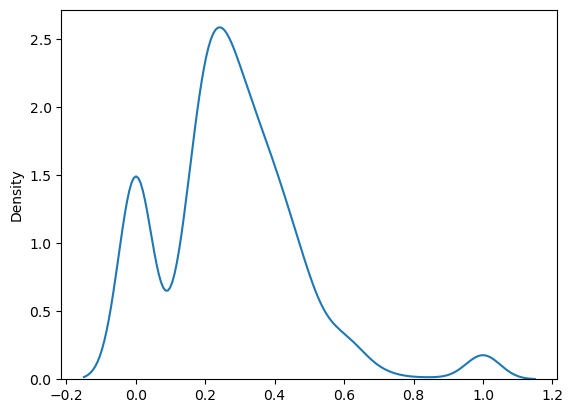

In [221]:
sns.kdeplot(generated_fps[0])

<Axes: ylabel='Density'>

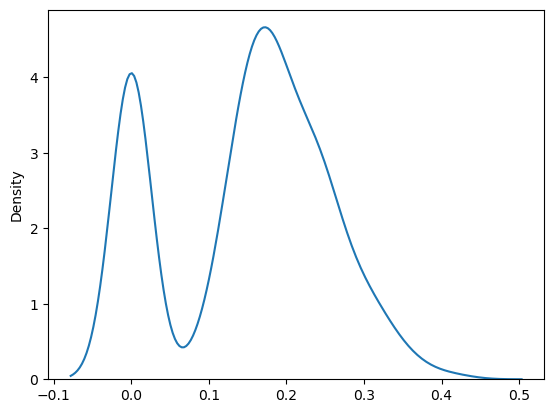

In [214]:
sns.kdeplot(generated_fps[1])

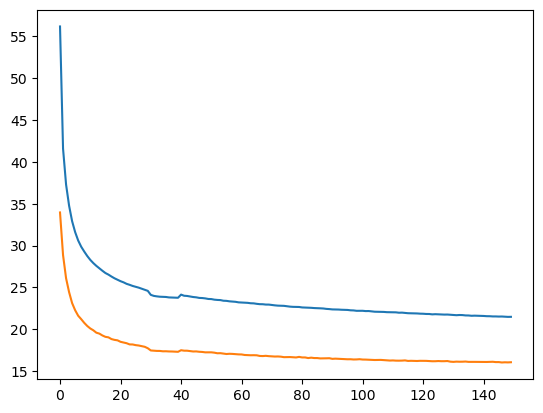

In [188]:
plt.plot(train_result)
plt.plot(val_result)

In [72]:
smiles = model.generateSmiles(batch_size=100, vocab=VOCAB)

for e in smiles:
    smile = "".join(e)
    print(sf.decoder(smile))
    

COC=CC=C(C1=CN=CC=C1CCCN2C(=O)C3=CC=CC=C32)CCl
COC=CCC=CC1=C(NNC(=O)C=C2C3=C(Cl)C=CC=N3)N=CCCCC=CC=C2C=N1
O=CCOC1CCNC=C1CCS(=O)(=O)C=CC2C3=CC=CC=C3CCC2C=CC=CS
C1=2C(CC(=O)C(C)CNC=O)C=C1C=2C=NCC
CCCCCC1=NC(N)C(=C)C1(C(=O)OCCCOC=CC=C(O)C=N)CCCC2=CC=CC=C2S
COC=C1C=CCNC(=O)NCC(=O)C=CC1(NNCC(=O)[NH1]C)CCC(=O)NCCNCC2CC(C)CC2
CC1C(OC)C=CC1C#N
O=C(CNC(=O)C(C)CCC(C)CC1C2)C(O)C=CC(Br)=C2NCNC=CC=CC(=O)OCC=C(F)C(F)=C1CC(F)C
N=C(S)C=O
C1OC=CC=C2CNOC2(CSCC=C1C3)CC(C)CC3CC=O
O=CC1(O)C=CC=C1C(=O)CC[NH1]N=C(C2=CC=CC=C2)NN=CC=C3CC4=CC=CC=C4C=N3
CS(=O)(=C)C=C(C(C12CC=CC(=C1)C)=CC=CC3=CC=CC=C3C(C4=CC=CC=C4CC2CCC)C)CC=O
N#CC=CC=CNC=CC=C(C)Cl
C1C=NN=C(C=O)CCCC=C1
CC(C)CC(C(=O)N1CC2C3SC(=O)NC=NC=CC=C(Cl)C)=C3N2C=C(OS)C1=C
CCCCCCCCNC(=O)CCOCCOCC=CS(=O)(=O)C1=CC=CC=C1CCCCNC=N
CC(C)CC(CCC1CCCC=C1N)C=C(C)CC2=CC=CC=C2[N+1](=O)[O-1]
CCN(C#N)C=C1C=CC=C1N2CC=CC=C(C3)N23
CC(C)CCNCC=C1C(=O)ONC2=C(CN=C2NC=C)C=C1[NH1]C=C=CC=CC=C
CC(=O)C1=CC=C2C=C1NC(=O)C=CC=C(O3)C2C=CC=C3
COCC=CC(C(=O)N)C(C)CCCCC(N)=O
CC=CCCC1CNC(=O)CC1